In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.metrics import classification_report
import torch.nn.functional as F
import torch
import os
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from pytorch_transformers import (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer)
import time
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import re

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

def clean_text(text):
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    if len(text.split()) < 8:
        return np.nan
    return text

In [3]:
df = import_data('../../../data/category-data/temp-files/dummy.csv')
df = df.where(df['video']==0).dropna()
df = df.drop('video', axis=1)
df['id'] = df['id'].astype('int64')
for col in df.columns[2:]:
    df[col] = df[col].astype('int8')
print('Dataset shape:', df.shape)
df.head()

Memory usage of dataframe is 82.86 MB
Memory usage after optimization is: 38.74 MB
Decreased by 53.2%
Dataset shape: (636494, 16)


,id,headline,books,"business, economy, trade",education,environment,film,health,media,"politics, government",science,south-asia,sports,tech,woman,world
0,0,win over cena satisfying but defeating underta...,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,Raju Chacha,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,87,'Devdas': Jinxed?,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,128,Car dealers caught in Bihar sales tax ruling,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,133,Space Cowboys,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [4]:
df['headline'] = df['headline'].apply(lambda text: clean_text(text))
df = df.dropna()
print('Length of df:', len(df))

Length of df: 344594


In [5]:
labels = np.argmax(df.iloc[:, 2:].values, axis=1).tolist()
print('Length of labels:', len(labels))

Length of labels: 344594


In [6]:
classes = list(df.columns[2:])
classes

['books',
 'business, economy, trade',
 'education',
 'environment',
 'film',
 'health',
 'media',
 'politics, government',
 'science',
 'south-asia',
 'sports',
 'tech',
 'woman',
 'world']

### For 6000 instances dataset

In [9]:
df = pd.read_csv('../../../data/category-data/temp-files/dummy_6000_14cats.csv')
encoder = LabelEncoder()
df['category'] = encoder.fit_transform(df['category'])
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (81584, 2)


,category,headline
0,0,Books that talk about transhumanism
1,0,Facts about revered author and Nobel Prize win...
2,0,Kolkata boy pens debut novel
3,0,Harry Potter documentary to air on TV
4,0,Forthcoming adaptation of 'A Christmas Carol' ...


In [ ]:
labels = df['category'].values
labels[2019]

In [10]:
classes = encoder.classes_.tolist()
classes

['books',
 'business, economy, trade',
 'education',
 'environment',
 'film',
 'health',
 'media',
 'politics, government',
 'science',
 'south-asia',
 'sports',
 'tech',
 'woman',
 'world']

## Common steps

In [10]:
sentences = df.headline.to_list()
sentences[2019]

'Jacob Martin to lead West Zone in Deodhar Trophy'

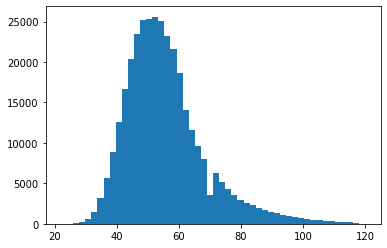

In [11]:
plt.hist([len(sen) for sen in sentences], bins=50)
plt.show()

In [12]:
len(labels)

344594

In [13]:
tag2idx = {str(i) : i for i in range(14)}
tag2idx

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '10': 10,
 '11': 11,
 '12': 12,
 '13': 13}

In [14]:
tag2name={tag2idx[key] : key for key in tag2idx.keys()}
tag2name

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '10',
 11: '11',
 12: '12',
 13: '13'}

In [15]:
vocabulary = 'data/xlnet-base-cased/xlnet-base-cased-spiece.model'
tokenizer = XLNetTokenizer(vocab_file=vocabulary,do_lower_case=False)
max_len = 60

In [16]:
full_input_ids = []
full_input_masks = []
full_segment_ids = []

SEG_ID_A   = 0
SEG_ID_B   = 1
SEG_ID_CLS = 2
SEG_ID_SEP = 3
SEG_ID_PAD = 4

UNK_ID = tokenizer.encode("<unk>")[0]
CLS_ID = tokenizer.encode("<cls>")[0]
SEP_ID = tokenizer.encode("<sep>")[0]
MASK_ID = tokenizer.encode("<mask>")[0]
EOD_ID = tokenizer.encode("<eod>")[0]

for i,sentence in enumerate(sentences):
    # Tokenize sentence to token id list
    tokens_a = tokenizer.encode(sentence)
    
    # Trim the len of text
    if(len(tokens_a)>max_len-2):
        tokens_a = tokens_a[:max_len-2]
        
        
    tokens = []
    segment_ids = []
    
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(SEG_ID_A)
        
    # Add <sep> token 
    tokens.append(SEP_ID)
    segment_ids.append(SEG_ID_A)
    
    
    # Add <cls> token
    tokens.append(CLS_ID)
    segment_ids.append(SEG_ID_CLS)
    
    input_ids = tokens
    
    # The mask has 0 for real tokens and 1 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [0] * len(input_ids)

    # Zero-pad up to the sequence length at fornt
    if len(input_ids) < max_len:
        delta_len = max_len - len(input_ids)
        input_ids = [0] * delta_len + input_ids
        input_mask = [1] * delta_len + input_mask
        segment_ids = [SEG_ID_PAD] * delta_len + segment_ids

    assert len(input_ids) == max_len
    assert len(input_mask) == max_len
    assert len(segment_ids) == max_len
    
    full_input_ids.append(input_ids)
    full_input_masks.append(input_mask)
    full_segment_ids.append(segment_ids)
    
    if 3 > i:
        print("No:%d"%(i))
        print("Sentence: %s"%(sentence))
        print("input_ids:%s"%(input_ids))
        print("attention_masks:%s"%(input_mask))
        print("segment_ids:%s"%(segment_ids))
        print("\n")

No:0
Sentence: win over cena satisfying but defeating undertaker bigger roman reigns
input_ids:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 521, 95, 17, 1138, 597, 16385, 57, 10348, 13032, 213, 3998, 17, 986, 249, 7542, 23, 4, 3]
attention_masks:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
segment_ids:[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]


No:1
Sentence: Car dealers caught in Bihar sales tax ruling
input_ids:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1561, 5418, 1976, 25, 24174, 820, 860, 2111, 4, 3]
attention_masks:[1, 1, 1

In [17]:
tags = [tag2idx[str(lab)] for lab in labels]
print(tags[0])

10


In [18]:
tr_inputs, val_inputs, tr_tags, val_tags, tr_masks, val_masks, tr_segs, val_segs = train_test_split(
    full_input_ids, tags, full_input_masks, full_segment_ids, random_state=2019, test_size=0.2)

In [19]:
len(tr_inputs),len(val_inputs),len(tr_segs),len(val_segs)

(275675, 68919, 275675, 68919)

In [20]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
tr_segs = torch.tensor(tr_segs)
val_segs = torch.tensor(val_segs)

In [21]:
batch_num = 32

In [22]:
# Set token embedding, attention embedding, segment embedding
train_data = TensorDataset(tr_inputs, tr_masks,tr_segs, tr_tags)
train_sampler = RandomSampler(train_data)
# Drop last can make batch training better for the last one
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

valid_data = TensorDataset(val_inputs, val_masks,val_segs, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_num)

## Training Model

In [65]:
model_file_address = 'data/xlnet-base-cased/'

In [66]:
model = XLNetForSequenceClassification.from_pretrained(model_file_address, num_labels=len(tag2idx))

In [67]:
device = 'cpu'
model.to(device);

In [68]:
epochs = 1
max_grad_norm = 1.0

In [69]:
num_train_optimization_steps = int( math.ceil(len(tr_inputs) / batch_num) / 1) * epochs

In [70]:
FULL_FINETUNING = False

In [71]:
if FULL_FINETUNING:
    # Fine tune model all layer parameters
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    # Only fine tune classifier parameters
    param_optimizer = list(model.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [72]:
model.train();

In [ ]:
print("***** Running training *****")
print("  Num examples = %d"%(len(tr_inputs)))
print("  Batch size = %d"%(batch_num))
print("  Num steps = %d"%(num_train_optimization_steps))

for _ in trange(epochs,desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_segs,b_labels = batch
        
        # forward pass
        outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        loss, logits = outputs[:2]        
        
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        
    # print train loss per epoch
    t = time.localtime()
    current_time = time.strftime("%H:%M:%S", t)
    print(current_time)
    print("Train loss: {}".format(tr_loss/nb_tr_steps))

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 275675
  Batch size = 32
  Num steps = 8615


In [ ]:
xlnet_out_address = 'data/xlnet_out_model/large'
if not os.path.exists(xlnet_out_address):
    os.makedirs(xlnet_out_address)

In [ ]:
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self

In [ ]:
output_model_file = os.path.join(xlnet_out_address, "pytorch_model.bin")
output_config_file = os.path.join(xlnet_out_address, "config.json")

In [ ]:
torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(xlnet_out_address)

### Load model

In [23]:
xlnet_out_address = 'data/xlnet_out_model/full'

In [24]:
model = XLNetForSequenceClassification.from_pretrained(xlnet_out_address,num_labels=len(tag2idx))
model.to('cpu')

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): XLNetLayerNorm()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): XLNetLayerNorm()
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): XLNetLayerNorm()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): XLNetLayerNorm()
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=307

In [25]:
model.eval();
device='cpu'

In [26]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

In [35]:
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
start = time.time()
y_true = []
y_predict = []
print("***** Running evaluation *****")
print("  Num examples = {}".format(len(val_inputs)))
print("  Batch size = {}".format(batch_num))
for step, batch in enumerate(valid_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_segs,b_labels = batch
    
    with torch.no_grad():
        outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        tmp_eval_loss, logits = outputs[:2]
    
    # Get textclassification predict result
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)
#     print(tmp_eval_accuracy)
#     print(np.argmax(logits, axis=1))
#     print(label_ids)
    
    # Save predict and real label reuslt for analyze
    for predict in np.argmax(logits, axis=1):
        y_predict.append(predict)
        
    for real_result in label_ids.tolist():
        y_true.append(real_result)

    
    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy
    
    nb_eval_steps += 1
    print("Step {}/{}, Time: {}".format(step, len(valid_dataloader), (time.time()-start)))

***** Running evaluation *****
  Num examples = 68919
  Batch size = 32
Step 0/2154, Time: 2.058565139770508
Step 1/2154, Time: 4.116827964782715
Step 2/2154, Time: 6.117296934127808
Step 3/2154, Time: 8.072669267654419
Step 4/2154, Time: 10.048367738723755
Step 5/2154, Time: 12.012305498123169
Step 6/2154, Time: 13.956593990325928
Step 7/2154, Time: 15.927215576171875
Step 8/2154, Time: 17.929190397262573
Step 9/2154, Time: 19.928521633148193
Step 10/2154, Time: 21.91372585296631
Step 11/2154, Time: 23.884004831314087
Step 12/2154, Time: 25.829570770263672
Step 13/2154, Time: 27.788087129592896
Step 14/2154, Time: 29.719520092010498
Step 15/2154, Time: 31.685009002685547
Step 16/2154, Time: 33.6481568813324
Step 17/2154, Time: 35.68223786354065
Step 18/2154, Time: 37.65757393836975
Step 19/2154, Time: 39.63903522491455
Step 20/2154, Time: 41.62599563598633
Step 21/2154, Time: 43.60842800140381
Step 22/2154, Time: 45.570337772369385
Step 23/2154, Time: 47.55925130844116
Step 24/2154, T

Step 209/2154, Time: 437.5579080581665
Step 210/2154, Time: 440.1875305175781
Step 211/2154, Time: 442.78924679756165
Step 212/2154, Time: 445.4119930267334
Step 213/2154, Time: 448.0423836708069
Step 214/2154, Time: 450.6474368572235
Step 215/2154, Time: 453.3138062953949
Step 216/2154, Time: 455.96664929389954
Step 217/2154, Time: 458.654123544693
Step 218/2154, Time: 461.2966423034668
Step 219/2154, Time: 463.9045841693878
Step 220/2154, Time: 466.50780868530273
Step 221/2154, Time: 469.16724491119385
Step 222/2154, Time: 471.75792813301086
Step 223/2154, Time: 474.4007947444916
Step 224/2154, Time: 476.9625623226166
Step 225/2154, Time: 479.52134251594543
Step 226/2154, Time: 482.198885679245
Step 227/2154, Time: 484.8117341995239
Step 228/2154, Time: 487.40658354759216
Step 229/2154, Time: 489.9855651855469
Step 230/2154, Time: 492.6002244949341
Step 231/2154, Time: 495.22651839256287
Step 232/2154, Time: 497.81153869628906
Step 233/2154, Time: 500.5310866832733
Step 234/2154, Tim

Step 420/2154, Time: 995.3077113628387
Step 421/2154, Time: 997.9527354240417
Step 422/2154, Time: 1000.5900962352753
Step 423/2154, Time: 1003.2270452976227
Step 424/2154, Time: 1005.8831541538239
Step 425/2154, Time: 1008.4882369041443
Step 426/2154, Time: 1011.093688249588
Step 427/2154, Time: 1013.7107756137848
Step 428/2154, Time: 1016.3277568817139
Step 429/2154, Time: 1018.971688747406
Step 430/2154, Time: 1021.6131906509399
Step 431/2154, Time: 1024.236198425293
Step 432/2154, Time: 1026.8650102615356
Step 433/2154, Time: 1029.4941017627716
Step 434/2154, Time: 1032.1031048297882
Step 435/2154, Time: 1034.716602563858
Step 436/2154, Time: 1037.322437763214
Step 437/2154, Time: 1039.9339628219604
Step 438/2154, Time: 1042.5744044780731
Step 439/2154, Time: 1045.1977798938751
Step 440/2154, Time: 1047.7842333316803
Step 441/2154, Time: 1050.4084248542786
Step 442/2154, Time: 1053.0355281829834
Step 443/2154, Time: 1055.6597983837128
Step 444/2154, Time: 1058.268693447113
Step 445

Step 627/2154, Time: 1540.5054605007172
Step 628/2154, Time: 1543.079144001007
Step 629/2154, Time: 1545.6651656627655
Step 630/2154, Time: 1548.2444927692413
Step 631/2154, Time: 1550.854588508606
Step 632/2154, Time: 1553.4415123462677
Step 633/2154, Time: 1555.9914901256561
Step 634/2154, Time: 1558.582041501999
Step 635/2154, Time: 1561.5255029201508
Step 636/2154, Time: 1564.0908591747284
Step 637/2154, Time: 1566.6651310920715
Step 638/2154, Time: 1569.5627171993256
Step 639/2154, Time: 1572.1165239810944
Step 640/2154, Time: 1574.7211427688599
Step 641/2154, Time: 1577.2947368621826
Step 642/2154, Time: 1579.874181985855
Step 643/2154, Time: 1582.4572112560272
Step 644/2154, Time: 1585.0285477638245
Step 645/2154, Time: 1587.6252052783966
Step 646/2154, Time: 1590.196801185608
Step 647/2154, Time: 1592.773035287857
Step 648/2154, Time: 1595.3535809516907
Step 649/2154, Time: 1598.0101132392883
Step 650/2154, Time: 1600.67378616333
Step 651/2154, Time: 1603.298984527588
Step 652/

Step 834/2154, Time: 2087.1053338050842
Step 835/2154, Time: 2089.961645126343
Step 836/2154, Time: 2092.5845804214478
Step 837/2154, Time: 2095.208400249481
Step 838/2154, Time: 2097.7660920619965
Step 839/2154, Time: 2100.9992792606354
Step 840/2154, Time: 2103.6590242385864
Step 841/2154, Time: 2106.3611459732056
Step 842/2154, Time: 2109.0211164951324
Step 843/2154, Time: 2111.6609013080597
Step 844/2154, Time: 2114.3265388011932
Step 845/2154, Time: 2116.9403591156006
Step 846/2154, Time: 2119.6044566631317
Step 847/2154, Time: 2122.316612482071
Step 848/2154, Time: 2125.0935413837433
Step 849/2154, Time: 2127.8430931568146
Step 850/2154, Time: 2130.5317239761353
Step 851/2154, Time: 2133.2317888736725
Step 852/2154, Time: 2135.9599652290344
Step 853/2154, Time: 2138.5903825759888
Step 854/2154, Time: 2141.2227885723114
Step 855/2154, Time: 2143.9120287895203
Step 856/2154, Time: 2146.519068002701
Step 857/2154, Time: 2149.128734588623
Step 858/2154, Time: 2151.7883048057556
Step 

Step 1041/2154, Time: 2636.5460023880005
Step 1042/2154, Time: 2639.1424655914307
Step 1043/2154, Time: 2641.7759177684784
Step 1044/2154, Time: 2644.5822727680206
Step 1045/2154, Time: 2647.2467288970947
Step 1046/2154, Time: 2649.8999741077423
Step 1047/2154, Time: 2652.573897123337
Step 1048/2154, Time: 2655.242826461792
Step 1049/2154, Time: 2657.8482251167297
Step 1050/2154, Time: 2660.504673719406
Step 1051/2154, Time: 2663.1616966724396
Step 1052/2154, Time: 2665.805102586746
Step 1053/2154, Time: 2668.4884090423584
Step 1054/2154, Time: 2671.142587661743
Step 1055/2154, Time: 2673.7988946437836
Step 1056/2154, Time: 2676.6928510665894
Step 1057/2154, Time: 2679.850227832794
Step 1058/2154, Time: 2682.525403738022
Step 1059/2154, Time: 2685.1798992156982
Step 1060/2154, Time: 2687.8466880321503
Step 1061/2154, Time: 2690.5126354694366
Step 1062/2154, Time: 2693.1121184825897
Step 1063/2154, Time: 2695.711005449295
Step 1064/2154, Time: 2698.334843635559
Step 1065/2154, Time: 270

Step 1244/2154, Time: 3179.0822138786316
Step 1245/2154, Time: 3181.699851989746
Step 1246/2154, Time: 3184.332240343094
Step 1247/2154, Time: 3186.9469010829926
Step 1248/2154, Time: 3189.5578503608704
Step 1249/2154, Time: 3192.184595823288
Step 1250/2154, Time: 3194.817701101303
Step 1251/2154, Time: 3197.446361541748
Step 1252/2154, Time: 3200.057911157608
Step 1253/2154, Time: 3202.663319349289
Step 1254/2154, Time: 3205.3012371063232
Step 1255/2154, Time: 3207.9068927764893
Step 1256/2154, Time: 3210.5154099464417
Step 1257/2154, Time: 3213.1592342853546
Step 1258/2154, Time: 3215.783844947815
Step 1259/2154, Time: 3218.399352788925
Step 1260/2154, Time: 3221.029688835144
Step 1261/2154, Time: 3223.6926531791687
Step 1262/2154, Time: 3226.2923424243927
Step 1263/2154, Time: 3228.9176898002625
Step 1264/2154, Time: 3231.5319259166718
Step 1265/2154, Time: 3234.144823074341
Step 1266/2154, Time: 3236.7515091896057
Step 1267/2154, Time: 3239.324738740921
Step 1268/2154, Time: 3241.9

Step 1447/2154, Time: 3721.2461502552032
Step 1448/2154, Time: 3723.886698484421
Step 1449/2154, Time: 3726.5693838596344
Step 1450/2154, Time: 3729.199965238571
Step 1451/2154, Time: 3731.8687999248505
Step 1452/2154, Time: 3734.5621078014374
Step 1453/2154, Time: 3737.185589313507
Step 1454/2154, Time: 3739.8575627803802
Step 1455/2154, Time: 3742.6172618865967
Step 1456/2154, Time: 3745.3149189949036
Step 1457/2154, Time: 3748.0118069648743
Step 1458/2154, Time: 3750.6089720726013
Step 1459/2154, Time: 3753.2314836978912
Step 1460/2154, Time: 3755.86852312088
Step 1461/2154, Time: 3758.4901394844055
Step 1462/2154, Time: 3761.140153646469
Step 1463/2154, Time: 3763.7747519016266
Step 1464/2154, Time: 3766.381455898285
Step 1465/2154, Time: 3769.0104401111603
Step 1466/2154, Time: 3771.6564614772797
Step 1467/2154, Time: 3774.2934119701385
Step 1468/2154, Time: 3776.9204630851746
Step 1469/2154, Time: 3779.515659093857
Step 1470/2154, Time: 3782.15762090683
Step 1471/2154, Time: 3784

Step 1651/2154, Time: 4258.741445541382
Step 1652/2154, Time: 4261.388769626617
Step 1653/2154, Time: 4264.057575464249
Step 1654/2154, Time: 4266.671103477478
Step 1655/2154, Time: 4269.2901611328125
Step 1656/2154, Time: 4271.899214744568
Step 1657/2154, Time: 4274.52746629715
Step 1658/2154, Time: 4277.177589178085
Step 1659/2154, Time: 4279.8231637477875
Step 1660/2154, Time: 4282.439126491547
Step 1661/2154, Time: 4285.055671453476
Step 1662/2154, Time: 4287.663063764572
Step 1663/2154, Time: 4290.311902046204
Step 1664/2154, Time: 4292.942944288254
Step 1665/2154, Time: 4295.576241016388
Step 1666/2154, Time: 4298.171683073044
Step 1667/2154, Time: 4300.968072652817
Step 1668/2154, Time: 4303.595594882965
Step 1669/2154, Time: 4306.306280612946
Step 1670/2154, Time: 4309.017590045929
Step 1671/2154, Time: 4312.081805944443
Step 1672/2154, Time: 4314.747366905212
Step 1673/2154, Time: 4317.357870340347
Step 1674/2154, Time: 4319.961059093475
Step 1675/2154, Time: 4322.566707372665

Step 1857/2154, Time: 4806.758140325546
Step 1858/2154, Time: 4809.42630314827
Step 1859/2154, Time: 4812.0722279548645
Step 1860/2154, Time: 4814.717814683914
Step 1861/2154, Time: 4817.369463920593
Step 1862/2154, Time: 4820.008325576782
Step 1863/2154, Time: 4822.663985013962
Step 1864/2154, Time: 4825.294516801834
Step 1865/2154, Time: 4827.906886339188
Step 1866/2154, Time: 4830.549315690994
Step 1867/2154, Time: 4833.223687648773
Step 1868/2154, Time: 4835.898121833801
Step 1869/2154, Time: 4838.5478229522705
Step 1870/2154, Time: 4841.229815006256
Step 1871/2154, Time: 4844.2009263038635
Step 1872/2154, Time: 4846.830392837524
Step 1873/2154, Time: 4849.459391593933
Step 1874/2154, Time: 4852.090004682541
Step 1875/2154, Time: 4854.686114311218
Step 1876/2154, Time: 4857.304954528809
Step 1877/2154, Time: 4859.964500665665
Step 1878/2154, Time: 4862.639591932297
Step 1879/2154, Time: 4865.684785366058
Step 1880/2154, Time: 4868.6214418411255
Step 1881/2154, Time: 4871.2433967590

Step 2062/2154, Time: 5355.394176721573
Step 2063/2154, Time: 5358.002749919891
Step 2064/2154, Time: 5360.666423797607
Step 2065/2154, Time: 5363.3176901340485
Step 2066/2154, Time: 5365.962517738342
Step 2067/2154, Time: 5368.605806827545
Step 2068/2154, Time: 5371.299738645554
Step 2069/2154, Time: 5373.949028968811
Step 2070/2154, Time: 5376.770485877991
Step 2071/2154, Time: 5379.372058391571
Step 2072/2154, Time: 5381.998076200485
Step 2073/2154, Time: 5384.6298995018005
Step 2074/2154, Time: 5387.283970355988
Step 2075/2154, Time: 5390.298720121384
Step 2076/2154, Time: 5392.981552362442
Step 2077/2154, Time: 5395.637998819351
Step 2078/2154, Time: 5398.322056531906
Step 2079/2154, Time: 5401.111547470093
Step 2080/2154, Time: 5403.737687587738
Step 2081/2154, Time: 5406.401791572571
Step 2082/2154, Time: 5409.020766496658
Step 2083/2154, Time: 5411.64852976799
Step 2084/2154, Time: 5414.298962593079
Step 2085/2154, Time: 5416.938599586487
Step 2086/2154, Time: 5419.583665132523

In [36]:
eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / len(val_inputs)
result = {'eval_loss': eval_loss,
                  'eval_accuracy': eval_accuracy}

report = classification_report(y_pred=np.array(y_predict),y_true=np.array(y_true), target_names=classes)

# Save the report into file
output_eval_file = os.path.join(xlnet_out_address, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    for key in sorted(result.keys()):
        print("  %s = %s"%(key, str(result[key])))
        writer.write("%s = %s\n" % (key, str(result[key])))
        
    print(report)
    writer.write("\n\n")  
    writer.write(report)

***** Eval results *****
  eval_accuracy = 0.8305982385118763
  eval_loss = 0.544364196124695
                          precision    recall  f1-score   support

                   books       0.23      0.98      0.37       207
business, economy, trade       0.94      0.82      0.87     17993
               education       0.79      0.96      0.87      1923
             environment       0.56      0.95      0.71       942
                    film       0.91      0.77      0.83     13511
                  health       0.67      0.76      0.72      1008
                   media       0.62      0.83      0.71      4241
    politics, government       0.76      0.93      0.83      1390
                 science       0.53      0.70      0.61      1173
              south-asia       0.40      0.95      0.56       437
                  sports       0.97      0.90      0.94     15249
                    tech       0.63      0.79      0.70      3195
                   woman       0.48      0.95  